## What do I need to do?

1. Get options data for CMCSA
    - Pick an options expiration date about 30 days from now
    - Get option chain for that expiration
2. Run MC sim on CMCSA
    - Get historical stock price
    - Create distribution
    - Run simulation
3. Calculate the likelihood of hitting each strike price

In [88]:
%matplotlib inline

import math
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
from scipy.stats import genextreme


In [2]:
cmcsa = yf.Ticker("CMCSA")

In [3]:
cmcsa.options

('2022-11-18',
 '2022-11-25',
 '2022-12-02',
 '2022-12-09',
 '2022-12-16',
 '2022-12-23',
 '2022-12-30',
 '2023-01-20',
 '2023-04-21',
 '2023-06-16',
 '2024-01-19',
 '2025-01-17')

In [4]:
option_date = '2022-12-16'

In [5]:
opt_chain = cmcsa.option_chain(option_date)

In [6]:
opt_chain

Options(calls=         contractSymbol             lastTradeDate  strike  lastPrice   bid  \
0  CMCSA221216C00025000 2022-11-09 17:31:58+00:00    25.0       7.04  9.35   
1  CMCSA221216C00027500 2022-11-10 16:52:23+00:00    27.5       5.30  6.90   
2  CMCSA221216C00030000 2022-11-15 18:21:58+00:00    30.0       4.74  0.00   
3  CMCSA221216C00032500 2022-11-16 14:30:02+00:00    32.5       2.47  0.00   
4  CMCSA221216C00035000 2022-11-16 14:30:02+00:00    35.0       0.98  0.00   
5  CMCSA221216C00037500 2022-11-15 20:47:23+00:00    37.5       0.35  0.00   
6  CMCSA221216C00040000 2022-11-15 19:21:32+00:00    40.0       0.10  0.06   
7  CMCSA221216C00042500 2022-11-14 17:22:43+00:00    42.5       0.05  0.02   
8  CMCSA221216C00045000 2022-11-15 17:43:50+00:00    45.0       0.03  0.00   

    ask  change  percentChange  volume  openInterest  impliedVolatility  \
0  9.80    0.00       0.000000       2            31           0.955079   
1  7.50    0.00       0.000000       2            11   

In [12]:
opt_chain.calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,CMCSA221216C00025000,2022-11-09 17:31:58+00:00,25.0,7.04,9.35,9.80,0.00,0.000000,2,31,0.955079,True,REGULAR,USD
1,CMCSA221216C00027500,2022-11-10 16:52:23+00:00,27.5,5.30,6.90,7.50,0.00,0.000000,2,11,0.789065,True,REGULAR,USD
2,CMCSA221216C00030000,2022-11-15 18:21:58+00:00,30.0,4.74,0.00,0.00,0.00,0.000000,3,6277,0.000010,True,REGULAR,USD
3,CMCSA221216C00032500,2022-11-16 14:30:02+00:00,32.5,2.47,0.00,0.00,0.02,0.816326,1,13932,0.000010,True,REGULAR,USD
4,CMCSA221216C00035000,2022-11-16 14:30:02+00:00,35.0,0.98,0.00,0.00,-0.07,-6.666660,1,6727,0.031260,False,REGULAR,USD
5,CMCSA221216C00037500,2022-11-15 20:47:23+00:00,37.5,0.35,0.00,0.00,0.00,0.000000,4519,6610,0.062509,False,REGULAR,USD
6,CMCSA221216C00040000,2022-11-15 19:21:32+00:00,40.0,0.10,0.06,0.16,0.00,0.000000,247,4436,0.398444,False,REGULAR,USD
7,CMCSA221216C00042500,2022-11-14 17:22:43+00:00,42.5,0.05,0.02,0.08,0.00,0.000000,2,7,0.437506,False,REGULAR,USD
8,CMCSA221216C00045000,2022-11-15 17:43:50+00:00,45.0,0.03,0.00,0.00,0.00,0.000000,66,65,0.250007,False,REGULAR,USD


In [59]:
hist_price = cmcsa.history(period = "max")

In [60]:
hist_price['Date'] = hist_price.index

In [61]:
hist_price

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
Date,,,,,,,,
1980-03-17 00:00:00-05:00,0.000000,0.071825,0.068769,0.068769,138396,0.0,0.0,1980-03-17 00:00:00-05:00
1980-03-18 00:00:00-05:00,0.000000,0.071825,0.068769,0.068769,530518,0.0,0.0,1980-03-18 00:00:00-05:00
1980-03-19 00:00:00-05:00,0.000000,0.071061,0.068004,0.068004,738113,0.0,0.0,1980-03-19 00:00:00-05:00
1980-03-20 00:00:00-05:00,0.000000,0.076410,0.073353,0.073353,1360895,0.0,0.0,1980-03-20 00:00:00-05:00
1980-03-21 00:00:00-05:00,0.000000,0.078702,0.075646,0.075646,461320,0.0,0.0,1980-03-21 00:00:00-05:00
...,...,...,...,...,...,...,...,...
2022-11-10 00:00:00-05:00,32.730000,32.900002,32.160000,32.770000,31529100,0.0,0.0,2022-11-10 00:00:00-05:00
2022-11-11 00:00:00-05:00,33.130001,34.060001,32.830002,34.020000,24484500,0.0,0.0,2022-11-11 00:00:00-05:00
2022-11-14 00:00:00-05:00,33.910000,34.660000,33.810001,34.130001,28778100,0.0,0.0,2022-11-14 00:00:00-05:00


<AxesSubplot: xlabel='Date'>

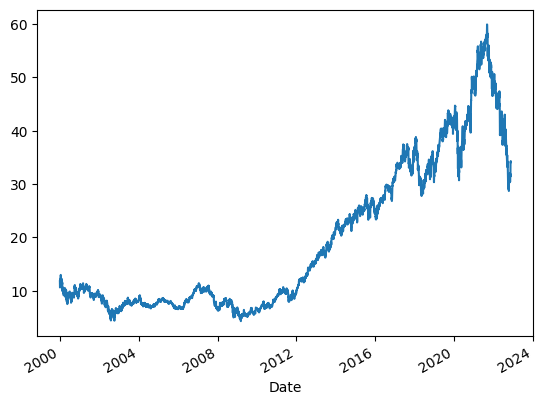

In [29]:
hist_price.loc[hist_price['Date'] >= '2000-01-01', 'Close'].plot()

In [71]:
hist_price['perc_change'] = (hist_price['Close'] - hist_price['Open']) / hist_price['Open']

<AxesSubplot: xlabel='Date'>

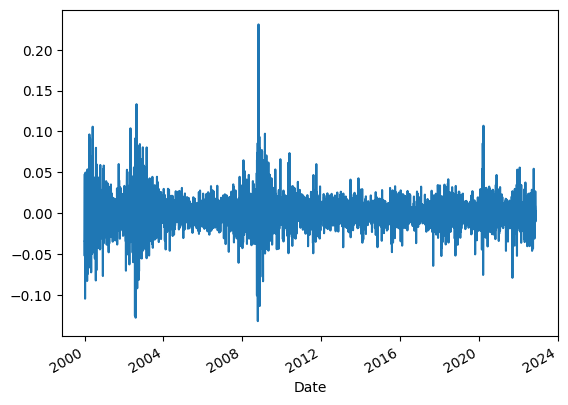

In [72]:
hist_price.loc[hist_price['Date'] >= '2000-01-01', 'perc_change'].plot()

In [83]:
hist_price = hist_price.loc[hist_price['Date'] >= '2000-01-01']

In [73]:
upper_scale = 0.60
lower_scale = 0.65
upper_shape = 0.09
lower_shape = 0.1
sample_size = 20000

today = datetime.utcnow().date()
start = today - timedelta(days = 90)
end = today

start = start.isoformat()

In [74]:
hist_price.loc[hist_price['Date'] > start]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date,perc_change
Date,,,,,,,,,
2022-08-19 00:00:00-04:00,38.051598,38.448074,37.803802,38.339043,19692200,0.0,0.0,2022-08-19 00:00:00-04:00,0.007554
2022-08-22 00:00:00-04:00,38.289483,38.289483,37.209091,37.288383,21400200,0.0,0.0,2022-08-22 00:00:00-04:00,-0.026146
2022-08-23 00:00:00-04:00,37.318121,37.476711,36.891911,36.911736,16505700,0.0,0.0,2022-08-23 00:00:00-04:00,-0.010890
2022-08-24 00:00:00-04:00,36.881996,37.328030,36.743231,36.782879,17668300,0.0,0.0,2022-08-24 00:00:00-04:00,-0.002687
2022-08-25 00:00:00-04:00,36.961294,37.377589,36.703583,37.268559,21571000,0.0,0.0,2022-08-25 00:00:00-04:00,0.008313
...,...,...,...,...,...,...,...,...,...
2022-11-10 00:00:00-05:00,32.730000,32.900002,32.160000,32.770000,31529100,0.0,0.0,2022-11-10 00:00:00-05:00,0.001222
2022-11-11 00:00:00-05:00,33.130001,34.060001,32.830002,34.020000,24484500,0.0,0.0,2022-11-11 00:00:00-05:00,0.026864
2022-11-14 00:00:00-05:00,33.910000,34.660000,33.810001,34.130001,28778100,0.0,0.0,2022-11-14 00:00:00-05:00,0.006488


In [81]:
perc_pos = (
    sum(hist_price.loc[hist_price['Date'] > start, 'perc_change'] > 0) / 
    len(hist_price.loc[hist_price['Date'] > start, 'perc_change'])
)

perc_neg = 1 - perc_pos

In [86]:
avg = np.mean(hist_price['perc_change'])
std = np.std(hist_price['perc_change'])

0.01849513742750003

In [104]:
samp_upper = genextreme.rvs(upper_shape, 
                            loc = avg, 
                            scale = upper_scale * std,
                            size = round(sample_size * perc_pos))

samp_lower = -1 * genextreme.rvs(lower_shape, 
                                 loc = avg, 
                                 scale = lower_scale * std,
                                 size = round(sample_size * perc_neg))

samp = np.append(samp_upper, samp_lower)


In [105]:
samp

array([ 0.01471868,  0.00178932,  0.00376965, ...,  0.00282302,
        0.01713854, -0.01831207])